In [3]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import re

### Data

In [4]:
charting_df = pd.read_csv('data/charting-m-points.csv', encoding = "ISO-8859-1")

/var/folders/0w/7qj8hh4n3w53g1qsr8gf4s_w0000gn/T/ipykernel_39640/2249881497.py:1: DtypeWarning: Columns (8,9,29) have mixed types. Specify dtype option on import or set low_memory=False.
  charting_df = pd.read_csv('data/charting-m-points.csv', encoding = "ISO-8859-1")


In [5]:
charting_df.head(1)

,match_id,Pt,Set1,Set2,Gm1,Gm2,Pts,Gm#,TbSet,TB?,...,2ndIn,isAce,isUnret,isRallyWinner,isForced,isUnforced,isDouble,PtWinner,isSvrWinner,rallyCount
0,20220713-M-Newport-R16-Andy_Murray-Max_Purcell,1,0,0,0.0,0.0,0-0,1 (1),1,0,...,NaN,False,False,False,False,False,False,1,1,1


### Exploration

In [6]:
wimbeldon_chart_df = charting_df[charting_df['match_id'].str.contains('Wimbledon')]

#### Winning Shot Statistics

In [7]:
# get rows for both 1st and 2nd
wimbeldon_chart_1st = wimbeldon_chart_df[wimbeldon_chart_df['1st'].notna()]
wimbeldon_chart_2nd = wimbeldon_chart_df[wimbeldon_chart_df['2nd'].notna()]

In [8]:
rallys = wimbeldon_chart_1st['1st']
rallys = rallys.append(wimbeldon_chart_2nd['2nd'])

/var/folders/0w/7qj8hh4n3w53g1qsr8gf4s_w0000gn/T/ipykernel_39640/3234859012.py:2: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rallys = rallys.append(wimbeldon_chart_2nd['2nd'])


In [9]:
rallys.shape

(78705,)

In [10]:
# sequences of rallies that end with '*' represent a winner was hit
# winners_df_1st = wimbeldon_chart_1st[wimbeldon_chart_1st['1st'].str.contains("\*")]
# winners_df_2nd = wimbeldon_chart_2nd[wimbeldon_chart_2nd['2nd'].str.contains("\*")]
winning_shots = rallys[rallys.str.contains("\*")]

In [11]:
#winners_df = winners_df_1st['1st']
#winners_df = winners_df.append(winners_df_2nd['2nd'])

In [12]:
winning_shots.shape

(20290,)

In [13]:
# 1st value: winners
# 2nd value: total occurences of this shot selection in general
shot_map = {
    'f': [0, 0,'fh gs'],
    'b': [0, 0,'bh gs'],
    'r': [0, 0, 'fh slice'],
    's': [0, 0, 'bh slice'],
    'v': [0, 0,'fh volley'],
    'z': [0, 0,'bh volley'],
    'o': [0, 0,'oh smash'],
    'p': [0, 0,'bh smash'],
    'u': [0, 0,'fh drop'],
    'y': [0, 0,'bh drop'],
    'l': [0, 0,'fh lob'],
    'm': [0, 0,'bh lob'],
    'h': [0, 0,'fh hv'],
    'i': [0, 0,'bh hv'],
    'j': [0, 0,'fh sv'],
    'k': [0, 0,'bh sv'],
    't': [0, 0,'trickshot'],
    'q': [0, 0,'unknown'],
    'c': [0, 0,'challenge']
}

#### get winning shots

In [16]:
letter_regex = '[a-zA-Z]'

In [17]:
num_of_winning_shots = 0
for i in winning_shots:
    if len(i) > 2: # ignore aces for now
        winning_shot = i[-4:]
        match = re.search(r'{letter_regex}'.format(letter_regex=letter_regex), winning_shot)
        if match:
            shot = match[0]
            if shot == 'd':
                winning_shot = i[-5:]
                match = re.search(r'{letter_regex}'.format(letter_regex=letter_regex), winning_shot)  
                shot = match[0]
            num_of_winning_shots += 1
            shot_map[shot.lower()][0] += 1
            

In [18]:
shot_map

{'f': [4865, 0, 'fh gs'],
 'b': [2681, 0, 'bh gs'],
 'r': [91, 0, 'fh slice'],
 's': [311, 0, 'bh slice'],
 'v': [2122, 0, 'fh volley'],
 'z': [1896, 0, 'bh volley'],
 'o': [1221, 0, 'oh smash'],
 'p': [61, 0, 'bh smash'],
 'u': [165, 0, 'fh drop'],
 'y': [138, 0, 'bh drop'],
 'l': [93, 0, 'fh lob'],
 'm': [111, 0, 'bh lob'],
 'h': [81, 0, 'fh hv'],
 'i': [65, 0, 'bh hv'],
 'j': [139, 0, 'fh sv'],
 'k': [29, 0, 'bh sv'],
 't': [2, 0, 'trickshot'],
 'q': [10, 0, 'unknown'],
 'c': [244, 0, 'challenge']}

#### get total occurences of shot in general and build df for viz

In [20]:
all_rallys_str = ''.join(list(rallys))

In [21]:
df = []
for shot, stats in shot_map.items():
    total_shots = all_rallys_str.count(shot)
    stats[1] = total_shots
    df.append({
        'shot': stats[2],
        'total': stats[1],
        'winners': stats[0]
    })

In [22]:
shot_map

{'f': [4865, 63776, 'fh gs'],
 'b': [2681, 49124, 'bh gs'],
 'r': [91, 4477, 'fh slice'],
 's': [311, 22149, 'bh slice'],
 'v': [2122, 6178, 'fh volley'],
 'z': [1896, 7183, 'bh volley'],
 'o': [1221, 1978, 'oh smash'],
 'p': [61, 212, 'bh smash'],
 'u': [165, 667, 'fh drop'],
 'y': [138, 889, 'bh drop'],
 'l': [93, 1124, 'fh lob'],
 'm': [111, 2260, 'bh lob'],
 'h': [81, 1116, 'fh hv'],
 'i': [65, 1236, 'bh hv'],
 'j': [139, 302, 'fh sv'],
 'k': [29, 71, 'bh sv'],
 't': [2, 99, 'trickshot'],
 'q': [10, 134, 'unknown'],
 'c': [244, 2916, 'challenge']}

In [23]:
shot_selection_df = pd.DataFrame(df)

In [203]:
shot_selection_df =  shot_selection_df.sort_values("total", ascending=False)

In [217]:
shot_selection_df = shot_selection_df[shot_selection_df['total']>=6000]

### Plots

#### regular

/var/folders/0w/7qj8hh4n3w53g1qsr8gf4s_w0000gn/T/ipykernel_39640/2384458608.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylabels, size=22)


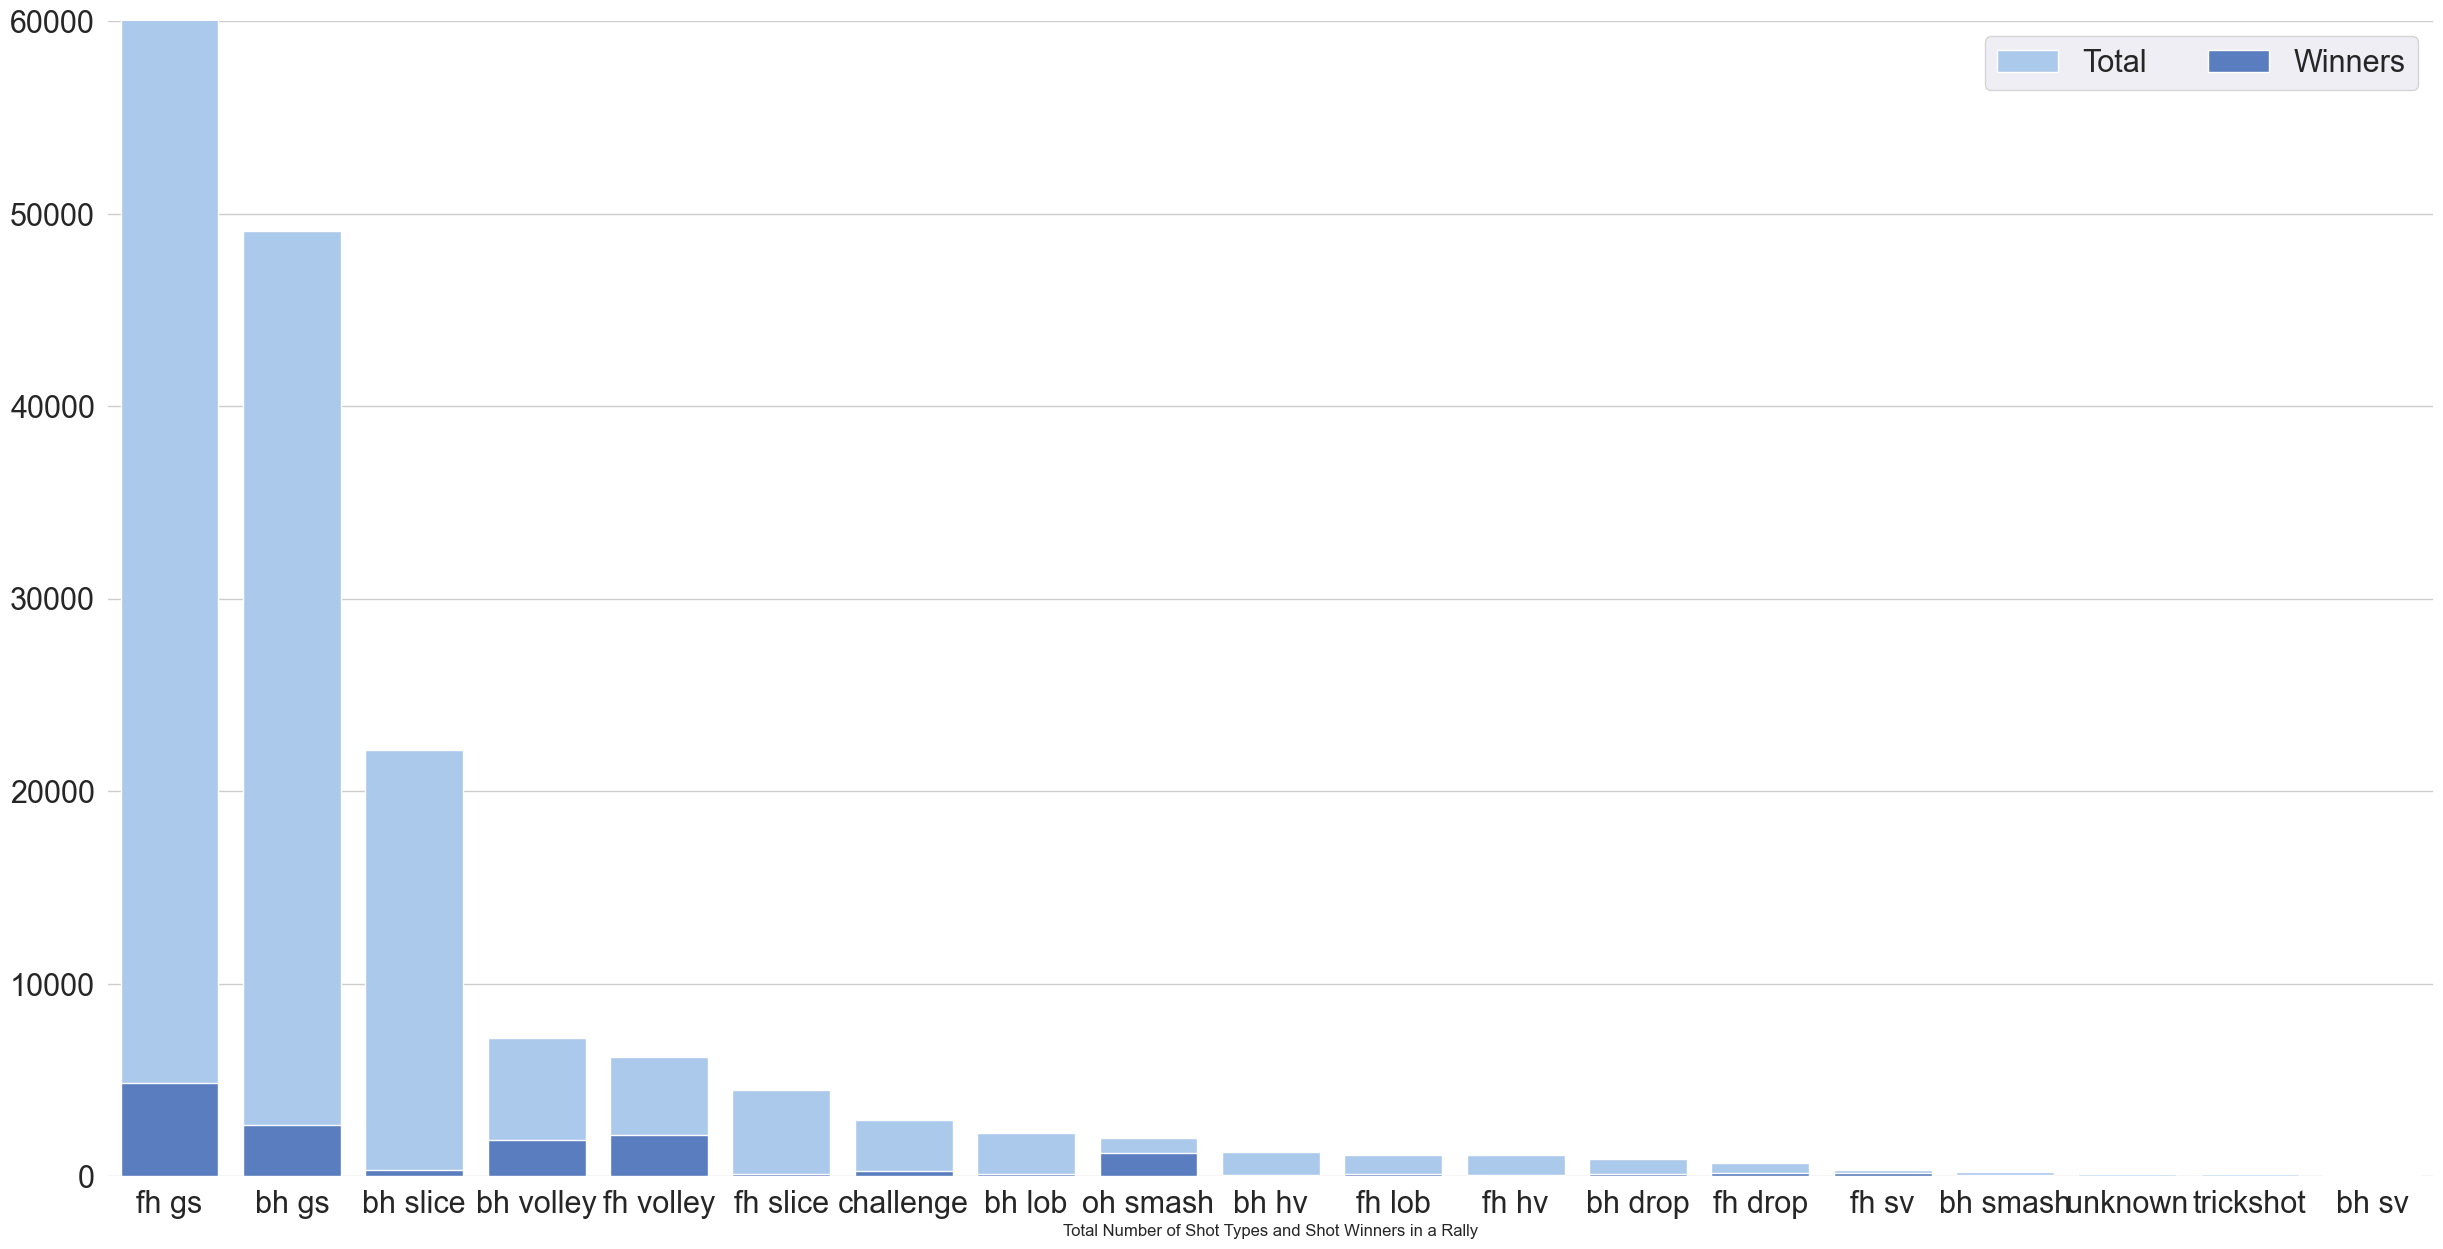

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(30, 15))

sns.set(font_scale=2)
sns.set_color_codes("pastel")
sns.barplot(x="shot", y="total", data=shot_selection_df,
            label="Total", color="b")


sns.set_color_codes("muted")
sns.barplot(x="shot", y="winners", data=shot_selection_df,
            label="Winners", color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="upper right", frameon=True)
ax.set(ylim=(0, 60000), ylabel="",
       xlabel="Total Number of Shot Types and Shot Winners in a Rally")

# get label text
_, xlabels = plt.xticks()

# set the x-labels with
ax.set_xticklabels(xlabels, size=22)

# get label text
_, ylabels = plt.yticks()

# set the y-labels with
ax.set_yticklabels(ylabels, size=22)

sns.despine(left=True, bottom=True)

In [40]:
f.savefig("shot_fig.png")

#### flipped

/var/folders/0w/7qj8hh4n3w53g1qsr8gf4s_w0000gn/T/ipykernel_39640/597388156.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabels, size=30)


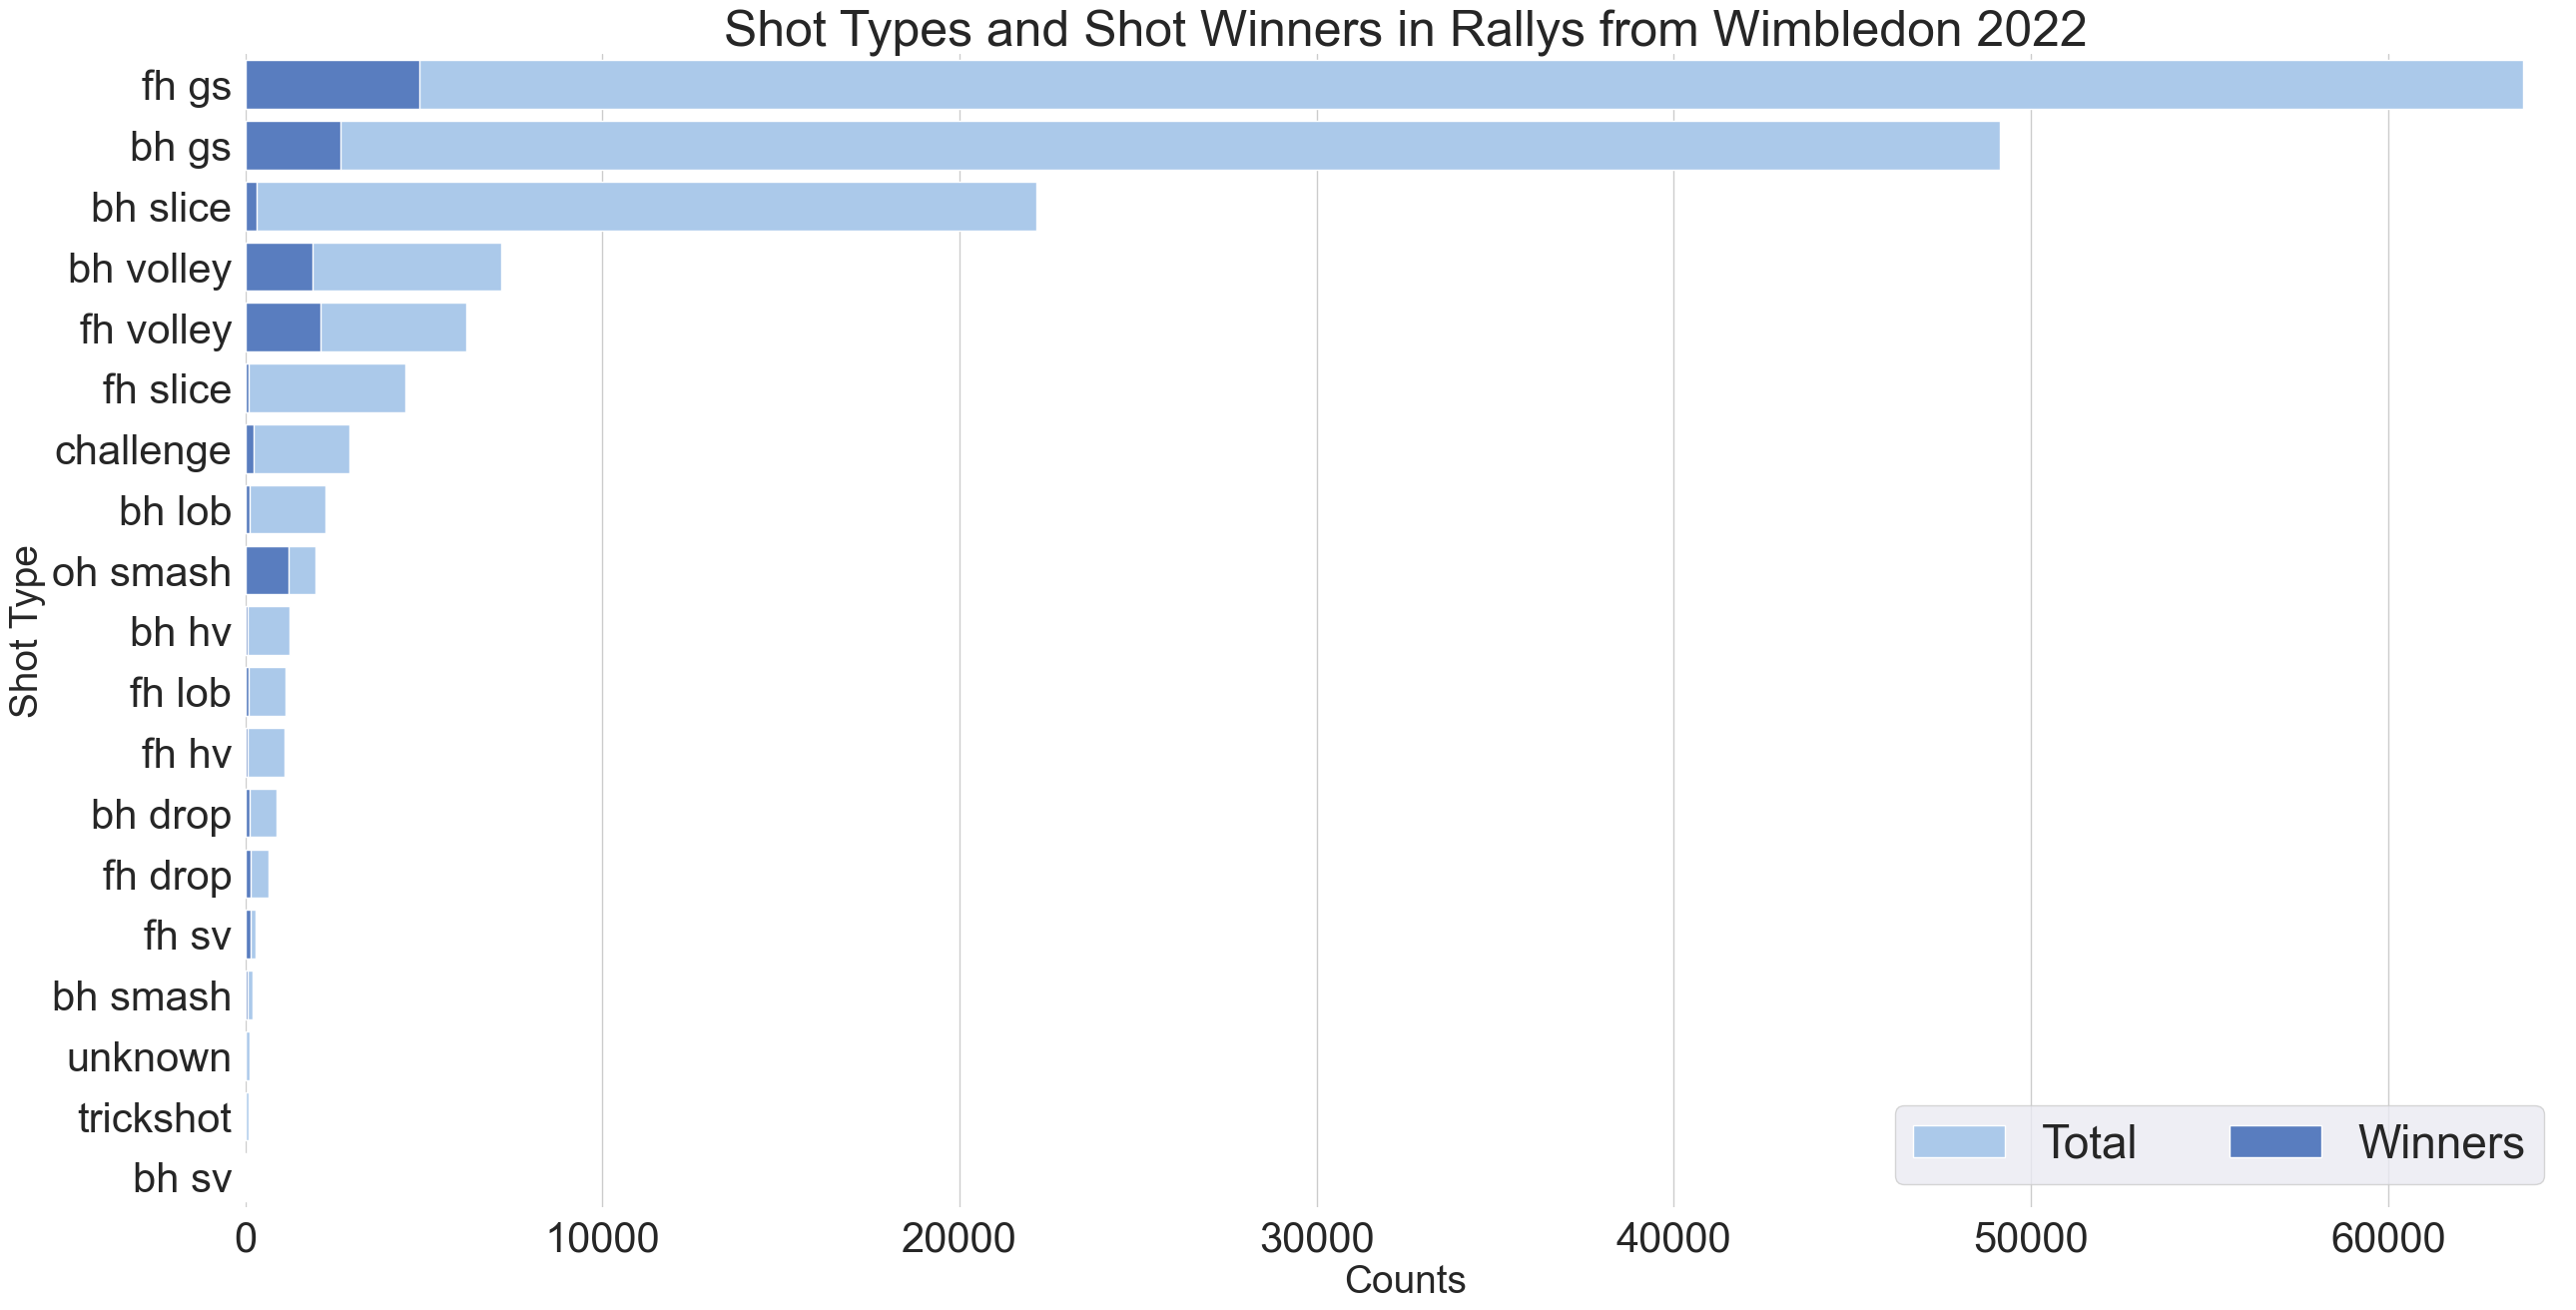

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

plt.rcParams["axes.labelsize"] = 28
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(30, 15))

sns.set(font_scale=3)
sns.set_color_codes("pastel")
sns.barplot(x="total", y="shot", data=shot_selection_df,
            label="Total", color="b").set_title('Shot Types and Shot Winners in Rallys from Wimbledon 2022')


sns.set_color_codes("muted")
sns.barplot(x="winners", y="shot", data=shot_selection_df,
            label="Winners", color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 65000), ylabel="Shot Type",
       xlabel="Counts")

# get label text
_, xlabels = plt.xticks()

# set the x-labels with
ax.set_xticklabels(xlabels, size=30)

# get label text
_, ylabels = plt.yticks()

# set the y-labels with
ax.set_yticklabels(ylabels, size=30)

sns.despine(left=True, bottom=True)

In [59]:
f.savefig("shot_fig_flipped.png")

### Percentages

In [24]:
shot_selection_df['winner_percentage'] = shot_selection_df['winners']/shot_selection_df['total']

In [25]:
shot_selection_df.sort_values("winners", ascending=False)

,shot,total,winners,winner_percentage
0,fh gs,63776,4865,0.076283
1,bh gs,49124,2681,0.054576
4,fh volley,6178,2122,0.343477
5,bh volley,7183,1896,0.263957
6,oh smash,1978,1221,0.617290
3,bh slice,22149,311,0.014041
18,challenge,2916,244,0.083676
8,fh drop,667,165,0.247376
14,fh sv,302,139,0.460265
9,bh drop,889,138,0.155231


In [26]:
shot_selection_df.sort_values("total", ascending=False)

,shot,total,winners,winner_percentage
0,fh gs,63776,4865,0.076283
1,bh gs,49124,2681,0.054576
3,bh slice,22149,311,0.014041
5,bh volley,7183,1896,0.263957
4,fh volley,6178,2122,0.343477
2,fh slice,4477,91,0.020326
18,challenge,2916,244,0.083676
11,bh lob,2260,111,0.049115
6,oh smash,1978,1221,0.617290
13,bh hv,1236,65,0.052589


In [27]:
shot_selection_df.sort_values("winner_percentage", ascending=False)

,shot,total,winners,winner_percentage
6,oh smash,1978,1221,0.617290
14,fh sv,302,139,0.460265
15,bh sv,71,29,0.408451
4,fh volley,6178,2122,0.343477
7,bh smash,212,61,0.287736
5,bh volley,7183,1896,0.263957
8,fh drop,667,165,0.247376
9,bh drop,889,138,0.155231
18,challenge,2916,244,0.083676
10,fh lob,1124,93,0.082740


## Last 2 shots

In [61]:
shot_map

{'f': [4865, 63776, 'fh gs'],
 'b': [2681, 49124, 'bh gs'],
 'r': [91, 4477, 'fh slice'],
 's': [311, 22149, 'bh slice'],
 'v': [2122, 6178, 'fh volley'],
 'z': [1896, 7183, 'bh volley'],
 'o': [1221, 1978, 'oh smash'],
 'p': [61, 212, 'bh smash'],
 'u': [165, 667, 'fh drop'],
 'y': [138, 889, 'bh drop'],
 'l': [93, 1124, 'fh lob'],
 'm': [111, 2260, 'bh lob'],
 'h': [81, 1116, 'fh hv'],
 'i': [65, 1236, 'bh hv'],
 'j': [139, 302, 'fh sv'],
 'k': [29, 71, 'bh sv'],
 't': [2, 99, 'trickshot'],
 'q': [10, 134, 'unknown'],
 'c': [244, 2916, 'challenge']}

In [72]:
shot_regex = '[fbrsvzopuylmhijktqc]'
shot_and_direction = '[fbrsvzopuylmhijktqc][123]'

In [67]:
match = re.findall(shot_regex, '6+s28z2m1o3*', flags=0)

In [74]:
match[-2]

'm'

In [79]:
winning_sequence = []
for rally in winning_shots:
    shots = re.findall(shot_and_direction, rally, flags=0)
    if len(shots) > 2:
        winning_sequence.append({
            'rally': rally,
            'receiving_shot': shots[-2],
            'winning_shot': shots[-1], 
            'combined': shots[-2] + shots[-1]
        })

In [80]:
winning_sequence_df = pd.DataFrame(winning_sequence)

In [101]:
# rallys of length greater than two
winning_sequence_df

,rally,receiving_shot,winning_shot,combined
0,6f2f2b2b3*,b2,b3,b2b3
1,4b2f3s2f+2b2v1f1*,v1,f1,v1f1
2,6s2f+3s2o1*,s2,o1,s2o1
3,5f2f3s3f3s2f1f2f2b2b3s1f2f1f1f3*,f1,f3,f1f3
4,5b2f3b2f1f3b2f3*,b2,f3,b2f3
...,...,...,...,...
7480,4+s17z1m2o1*,m2,o1,m2o1
7481,4+s17z3f3*,z3,f3,z3f3
7482,5+f17z1b3v3*,b3,v3,b3v3
7483,6+s28z2m1o3*,m1,o3,m1o3


In [99]:
winning_sequence_counts = pd.DataFrame(winning_sequence_df['combined'].value_counts())

In [102]:
winning_sequence_counts_top_ten = winning_sequence_counts.head(10)

In [104]:
winning_sequence_counts_top_ten['percentage of total winners'] = winning_sequence_counts_top_ten['combined'] / winning_sequence_df.shape[0] 

/var/folders/0w/7qj8hh4n3w53g1qsr8gf4s_w0000gn/T/ipykernel_39640/1416413489.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  winning_sequence_counts_top_ten['percentage of total winners'] = winning_sequence_counts_top_ten['combined'] / winning_sequence_df.shape[0]


In [105]:
winning_sequence_counts_top_ten

,combined,percentage of total winners
f1f3,197,0.026319
m2o1,197,0.026319
m2o3,162,0.021643
b1v1,152,0.020307
f1f1,135,0.018036
b2v1,117,0.015631
b3z1,110,0.014696
b2f1,108,0.014429
f3b1,107,0.014295
f3z3,104,0.013894
